In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-1, 1],
    c1 = 2.0,
    c2 = 2.0,
    w = 1.2,
    w_decay = 0.95,
    scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.8333333333333334, Loss: 0.6883799235026041
Checkpoint 200, Accuracy: 0.8271604938271605, Loss: 0.6677330158374928
Checkpoint 300, Accuracy: 0.8333333333333334, Loss: 0.6825021107991537


C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


Checkpoint 400, Accuracy: 0.8395061728395061, Loss: 0.6431973775227865
Checkpoint 500, Accuracy: 0.8395061728395061, Loss: 0.6431973775227865


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None and title is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

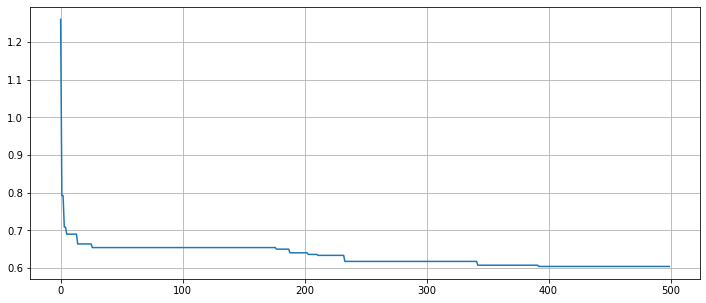

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 1. 0.] <-> [[0.37611064]
 [0.38887286]
 [0.23501648]]
[0. 1. 0.] <-> [[0.03629622]
 [0.435253  ]
 [0.5284508 ]]
[1. 0. 0.] <-> [[0.8913234 ]
 [0.06817822]
 [0.04049837]]
[1. 0. 0.] <-> [[0.89062625]
 [0.08002781]
 [0.02934595]]
[1. 0. 0.] <-> [[0.8910861 ]
 [0.08036921]
 [0.02854472]]
[1. 0. 0.] <-> [[0.89095926]
 [0.08044311]
 [0.02859768]]
[1. 0. 0.] <-> [[0.76285607]
 [0.13241448]
 [0.10472947]]
[0. 0. 1.] <-> [[0.63963693]
 [0.2597049 ]
 [0.10065819]]
[1. 0. 0.] <-> [[0.8912705 ]
 [0.07757118]
 [0.03115831]]
[1. 0. 0.] <-> [[0.89068705]
 [0.07966091]
 [0.02965208]]
[0. 0. 1.] <-> [[0.5364878 ]
 [0.30708948]
 [0.15642267]]
[1. 0. 0.] <-> [[0.89107513]
 [0.07822593]
 [0.03069898]]
[1. 0. 0.] <-> [[0.6375765 ]
 [0.22165842]
 [0.14076506]]
[1. 0. 0.] <-> [[0.8907484 ]
 [0.08048631]
 [0.02876535]]
[1. 0. 0.] <-> [[0.4031213 ]
 [0.37615046]
 [0.2207283 ]]
[1. 0. 0.] <-> [[0.89070857]
 [0.07956191]
 [0.0297295 ]]
[1. 0. 0.] <-> [[0.89062095]
 [0.08008717]
 [0.0292919 ]]
[1. 0. 0.] <->

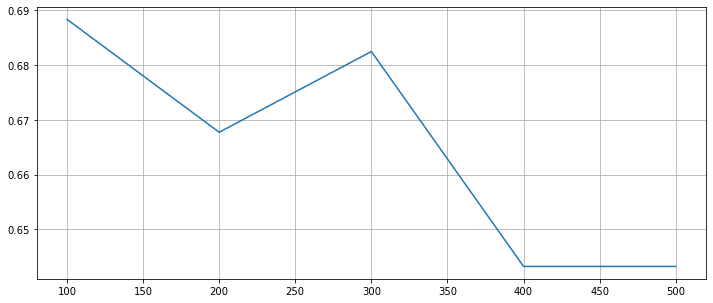

In [12]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

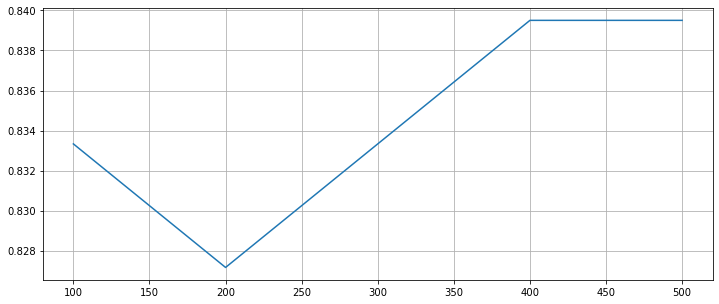

In [13]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[[ 3.        ]
 [ 3.        ]
 [-0.4212613 ]
 [ 0.21379474]
 [ 3.        ]]
 bias: [1.0491909]

Neuron 1: weights:
[[ 1.994554 ]
 [-1.3143352]
 [-3.       ]
 [-3.       ]
 [ 3.       ]]
 bias: [3.]

Neuron 2: weights:
[[ 3.       ]
 [ 1.002337 ]
 [ 0.9076685]
 [-3.       ]
 [ 2.601571 ]]
 bias: [1.6144074]

Neuron 3: weights:
[[-3.       ]
 [-3.       ]
 [-1.0117635]
 [-3.       ]
 [-0.8366878]]
 bias: [3.]

$
Layer 2
Neuron 0: weights:
[[-0.58680385]
 [ 3.        ]
 [ 1.99025   ]
 [-3.        ]]
 bias: [3.]

Neuron 1: weights:
[[ 3.        ]
 [-1.673117  ]
 [ 0.90068823]
 [-0.73281175]]
 bias: [3.]

Neuron 2: weights:
[[ 1.0984093 ]
 [-3.        ]
 [ 3.        ]
 [-0.44112682]]
 bias: [3.]

$

